## Tweet Emotion Recognition: Natural Language Processing with TensorFlow




## Task 1: Introduction

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [7]:
!pip install nlp

In [8]:
# imports packages

%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h): # this function will show accuracy loss etc for training
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# calculates our prediction against the ground truth using confusion matrix
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.19.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [10]:
# import dataset
!pip install -q datasets

from datasets import load_dataset
dataset = load_dataset("emotion")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
# take a look at dataset object we have
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [12]:
# creating three sets
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [15]:
# look at test and label key for each examples
def get_tweet(data):
  tweets = [x['text'] for x in data] # iterate over tweets
  labels = [x['label'] for x in data] # extract the labels too
  return tweets, labels

In [17]:
# get tweets and labels for training set
# pass train object here
tweets, labels = get_tweet(train)

In [21]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [23]:
# get tokenizer
# data should be like numbers to be trained
# unique word will get unique numbers
from tensorflow.keras.preprocessing.text import Tokenizer

In [26]:
# Tokenizing process
# anything that is not in 10000 most common words will be tokenized as UNK and there is a numerical value for UNK too
tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')

# create mapping from words to numerical values
tokenizer.fit_on_texts(tweets) # in this case these are tweets from training set

In [30]:
# what tokenizer process did: the list of numbers
tokenizer.texts_to_sequences([tweets[0]]) # passing as single element in a list

[[2, 139, 3, 679]]

In [31]:
[tweets[0]]

['i didnt feel humiliated']

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

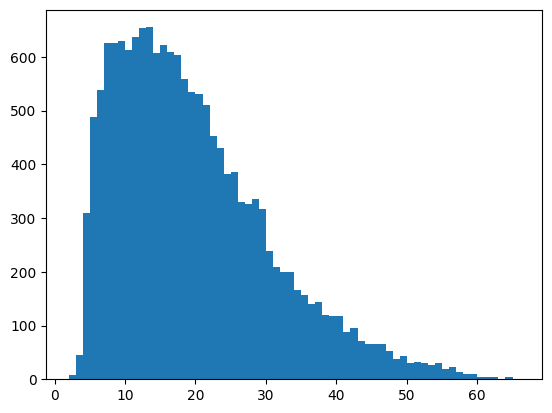

In [34]:
# the tweet lengths are different they have to be the same
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths))) # bins: number of unique lengths we have in data
plt.show()

In [35]:

maxlen = 50 # anything longer than this will be truncated otherwise will be padded
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
# this function will get sequences for our different sets
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  # specifying how truncate happen, the last elements will be added with that padding
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=maxlen)
  return padded

In [37]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [39]:
# we will get the same token as before but with the desired length
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [42]:
# we will have numeric values for different classes
# create set out of unique classes
classes = set(labels)
print(classes)

# the dataset we loaded already gives labels in numerical values
# seeing labels not numerical
label_names = dataset['train'].features['label'].names
print(label_names)

{0, 1, 2, 3, 4, 5}
['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


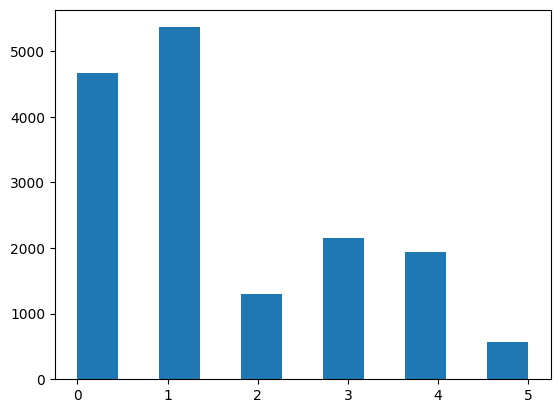

In [46]:
# take a look at number of example of each class
plt.hist(labels,  bins = 11)
plt.show()

In [ ]:
# create a function to convert names to IDs
names_to_ids =

In [51]:
# dataset of Hugging face "emotion" already give classes to index
# we create a class to index list by swapping pairs
label_names = dataset['train'].features['label'].names
index_to_class = dict(enumerate(label_names))
print(index_to_class)


{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [56]:
# Build a sequential model (a stack of layers run in order)
model = tf.keras.models.Sequential([

    # Layer 1: Embedding layer
    # Converts each word index (0–9999) into a 16-dimensional dense vector
    # input_length=maxlen fixes the input size so every tweet has same length
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),

    # Layer 2: Bidirectional LSTM
    # Reads the sequence forward and backward, capturing context from both directions
    # return_sequences=True means it outputs a full sequence for the next LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),

    # Layer 3: Another Bidirectional LSTM
    # Processes the previous sequence output and summarizes it into one final vector
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),

    # Layer 4: Dense (fully connected) output layer
    # 16 neurons (example) — one per possible emotion class, using softmax for probabilities
    tf.keras.layers.Dense(16, activation='softmax')
])

# Compile the model — define how it will learn
model.compile(

    # Use sparse_categorical_crossentropy since labels are integers (not one-hot vectors)
    loss='sparse_categorical_crossentropy',

    # Use Adam optimizer — adaptive learning rate for efficient training
    optimizer='adam',

    # Track accuracy during training
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [55]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [63]:
# prepare the validation set
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
print(val_labels[300])

2


In [64]:
val_tweets[0]

'im feeling quite sad and sorry for myself but ill snap out of it soon'

In [71]:
# convert your lists to numpy arrays before training
import numpy as np

labels = np.array(labels)
val_labels = np.array(val_labels)
padded_train_seq = np.array(padded_train_seq)
val_seq = np.array(val_seq)


In [72]:
# train the model
#
h = model.fit(
    padded_train_seq, labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        # if the model does not see any improvements in validation accuracy after two epochs, it will stop the training
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)



Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.3225 - loss: 1.8232 - val_accuracy: 0.5225 - val_loss: 1.4222
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5711 - loss: 1.2469 - val_accuracy: 0.6010 - val_loss: 1.1440
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6120 - loss: 1.0843 - val_accuracy: 0.5835 - val_loss: 1.0246
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6868 - loss: 0.8063 - val_accuracy: 0.7180 - val_loss: 0.7325
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7480 - loss: 0.5889 - val_accuracy: 0.7315 - val_loss: 0.7003
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7850 - loss: 0.5269 - val_accuracy: 0.7625 - val_loss: 0.6434
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8386 - loss: 0.4317 - val_accuracy: 0.8040 - val_loss: 0.5982
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8865 - loss: 0.3221 - val_ac

In [70]:
# checking something
print(labels[:5])   # should look like [0, 1, 2, 3, 4]
#print(labels)
print(padded_train_seq.shape)
print(len(labels))
#---
print(type(labels))
print(type(labels[0]))



[0, 0, 3, 2, 3]
(16000, 50)
16000
<class 'list'>
<class 'int'>


## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

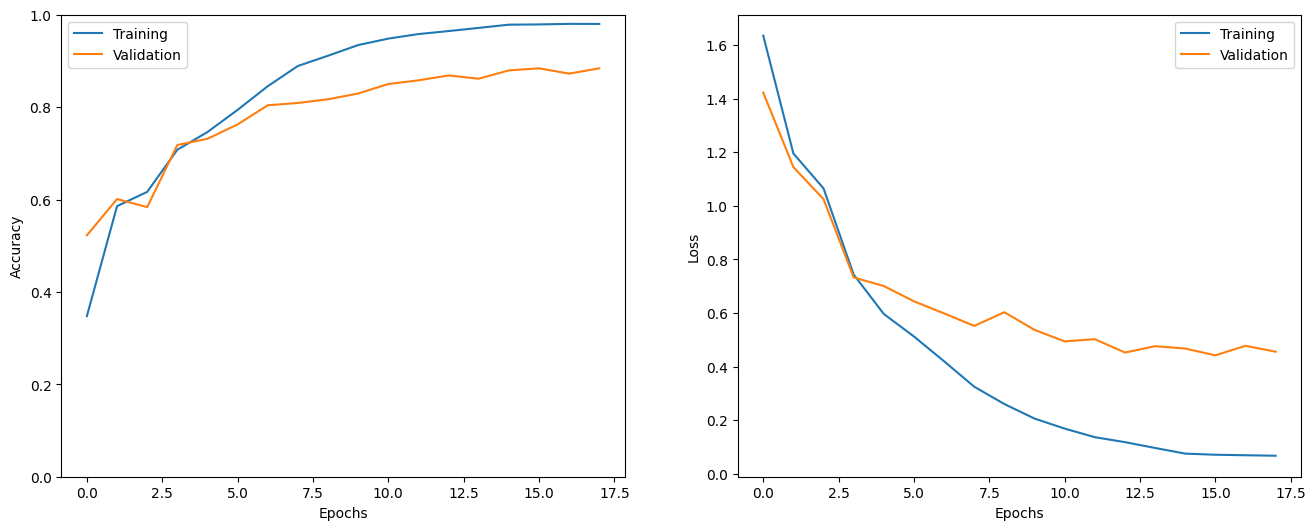

In [73]:
show_history(h) # pre-written before

In [74]:
# prepare the test set and evaluate performance but validation set was used kind of as a test set
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)

In [78]:
# checking something
import numpy as np
test_labels = np.array(test_labels)
test_seq = np.array(test_seq)

print(test_seq.shape)
print(test_labels.shape)
print(type(test_seq), type(test_labels))



(2000, 50)
(2000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [79]:
#
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8805 - loss: 0.4871


In [81]:
# look predictions manually
i = random.randint(0, len(test_seq) - 1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
print('Label:', test_labels[i])

Sentence: i just want that feeling of not caring about unnecessary stuff like i felt before
Emotion: love
Label: 2


In [85]:
import numpy as np
test_seq = np.array(test_seq)
preds = model.predict(test_seq)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


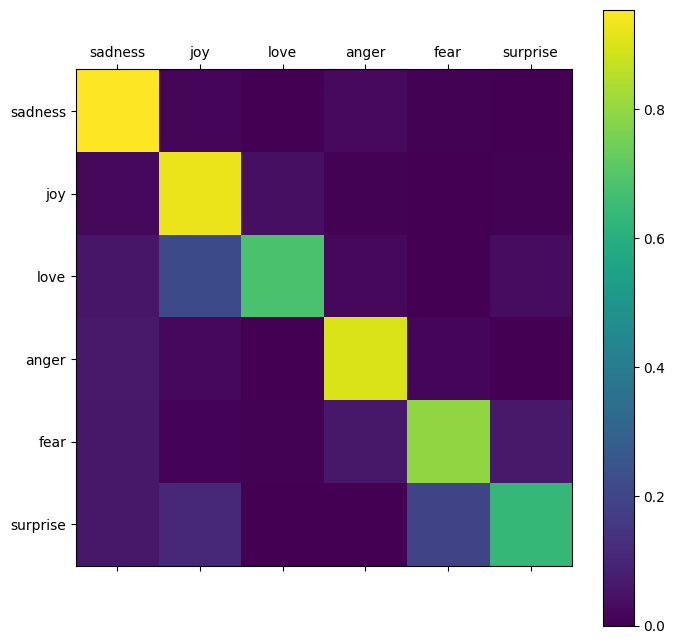

In [86]:
show_confusion_matrix(test_labels, np.argmax(preds, axis=1), label_names)
#